In [ ]:
!pip install transformers==3.0.2

  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)
  Using cached tokenizers-0.8.1rc1.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


**Importing the modules**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import spacy
import re
import string
import nltk
import torch
import seaborn as sns
import transformers
import json
import logging

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from torch import cuda
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import classification_report

from nltk.stem import PorterStemmer
nltk.download('punkt')
logging.basicConfig(level=logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Read the files**

In [ ]:
path_to_glove_file = "/content/glove.6B.50d.txt"
df = pd.read_excel("/content/LabeledText.xlsx")

In [ ]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


**EDA**

In [ ]:
def info1(df):
  print("Dataframe:\n",df)
  print("Shape fo the dataframe:",df.shape)

In [ ]:
info1(df)

Dataframe:
      File Name                                            Caption     LABEL
0        1.txt      How I feel today #legday #jelly #aching #gym   negative
1       10.txt  @ArrivaTW absolute disgrace two carriages from...  negative
2      100.txt  This is my Valentine's from 1 of my nephews. I...  positive
3     1000.txt  betterfeelingfilms: RT via Instagram: First da...   neutral
4     1001.txt         Zoe's first love #Rattled @JohnnyHarper15   positive
...        ...                                                ...       ...
4864   995.txt  OMG. Well done #Eskom! 'Man dies during #LoadS...  positive
4865   996.txt  Feelin' the love in here! #ValentinesDay #caring   positive
4866   997.txt                      #blue #eyes can't be #beaten    neutral
4867   998.txt              LA CHUCHA LOUUU TE CHUPO LOS OJOS..!    neutral
4868   999.txt  #colorsplash_bw #zealous Remedios #herbales y ...  positive

[4869 rows x 3 columns]
Shape fo the dataframe: (4869, 3)


**Visualising the Dataset**

In [ ]:
def pie1(df):
  global label_counts
  label_counts = df['LABEL'].value_counts()
  # Plot pie chart
  plt.figure(figsize=(4, 4))
  plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
  plt.title('Distribution of Labels')
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
  plt.show()

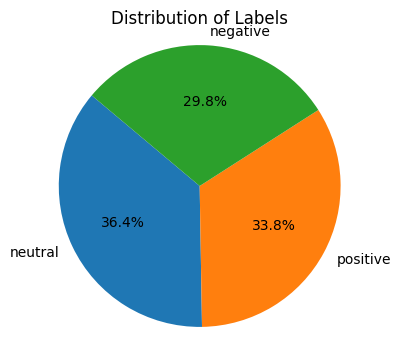

In [ ]:
pie1(df)

In [ ]:
def bar1(df):
  plt.figure(figsize=(6, 5))
  plt.bar(label_counts.index, label_counts.values, alpha=0.8)
  plt.title('Distribution of Labels')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.show()

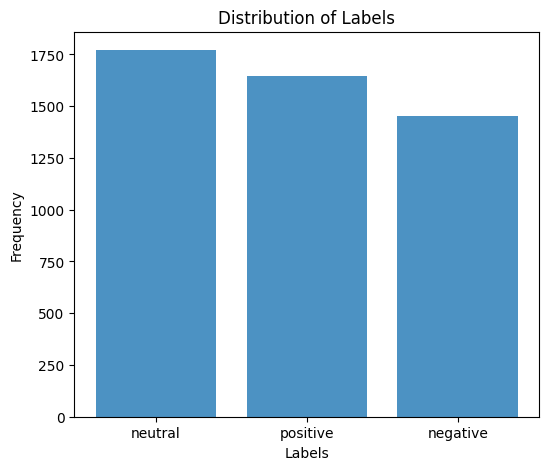

In [ ]:
bar1(df)

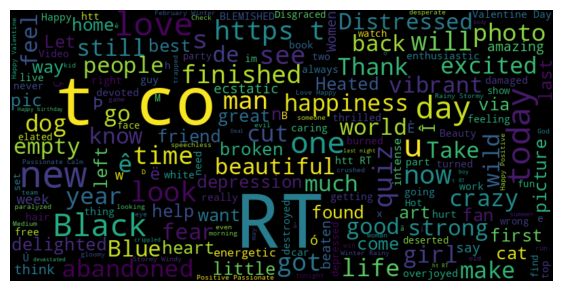

In [ ]:
from wordcloud import WordCloud
# Combine all the captions into one string
all_captions = ' '.join(df['Caption'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_captions)
plt.figure(figsize=(7,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Preprocessing**

In [ ]:
df_copy = df.copy()

In [ ]:
def lowercase(data):
  return data['Caption'].str.lower()

def change_punctuation(data):
    return data['Caption'].str.replace('`', "'")

def remove_numbers(data):
    return data['Caption'].replace('[^a-zA-z.,!?/:;\"\'\s]', '', regex=True)

def remove_special_characters(data):
    return data['Caption'].replace('[^a-zA-Z0-9 ]', '', regex=True)

def custom(data):
    return data['Caption'].replace('im', 'i am')

nlp = spacy.load("en_core_web_sm")
def lemmatize(data):
    lemmatized_array = []

    for text in data['Caption']:
        lemmatized_text = []
        doc = nlp(text)
        for token in doc:
            lemmatized_text.append(token.lemma_)
        lemmatized_array.append(' '.join(lemmatized_text))
    return lemmatized_array

def stop_words(data):
    stop_words_array = []
    for text in data['Caption']:
        doc = nlp(text)
        filtered_tokens = [token.text for token in doc if not token.is_stop]
        stop_words_array.append(' '.join(filtered_tokens))
    return stop_words_array

def stem_words(data):
    stemmer = PorterStemmer()
    stemmed_array = []
    for text in data['Caption']:
        tokens = nltk.word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        stemmed_array.append(' '.join(stemmed_tokens))
    return stemmed_array

def delete_links(data):
    return data['Caption'].replace(r'http\S+', '', regex=True)

def preprocessing(data):
    df['Caption'] = lowercase(df)
    df['Caption'] = custom(df)
    df['Caption'] = change_punctuation(df)
    df['Caption'] = lemmatize(df)
    df['Caption'] = remove_numbers(df)
    df['Caption'] = delete_links(df)
    df['Caption'] = stem_words(df)
    df['Caption'] = remove_special_characters(df)
    return df

In [ ]:
df_copy = preprocessing(df_copy)

In [ ]:
df_copy.drop_duplicates(subset=['Caption'], inplace=True)
df_copy['Caption'] = df_copy['Caption'].astype('str')

le = LabelEncoder()
df_copy['LABEL'] = le.fit_transform(df_copy['LABEL'])
df_copy

,File Name,Caption,LABEL
0,1.txt,how i feel today legday jelli ach gym,0
1,10.txt,arrivatw absolut disgrac two carriag from bang...,0
2,100.txt,thi be my valentin s from of my nephew i be e...,2
3,1000.txt,betterfeelingfilm rt via instagram first day...,1
4,1001.txt,zoe s first love rattl johnnyharp,2
...,...,...,...
4857,989.txt,big thank you to all of the teacher who attend...,2
4858,99.txt,dave look so elat,2
4860,991.txt,complet uniqu petrifi palm ear set in sterl si...,1
4861,992.txt,rt headquart to be fair everyth make i want ...,0


In [ ]:
X = df_copy['Caption']
y = df_copy['LABEL']

print("\nTarget Labels:",y)


Target Labels: 0       0
1       0
2       2
3       1
4       2
       ..
4857    2
4858    2
4860    1
4861    0
4865    2
Name: LABEL, Length: 4535, dtype: int64


In [ ]:
max_words = 9000
maxlen = 200
training_samples = int(len(X)*0.8)

In [ ]:
text_dataset = tf.data.Dataset.from_tensor_slices(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

max_features = 15000

vectorize_layer = tf.keras.layers.TextVectorization(
        max_tokens=max_words, # Max number of word in the internal dictionnary. We keep the most frequent
        output_mode='int',
        output_sequence_length=maxlen  # Size max of text
        )

vectorize_layer.adapt(text_dataset.batch(64))

voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
c = 0
for i,j in word_index.items():
  print(i,j,end= " ")
  c += 1
  if c==21 or c==42:
    print("\n")

 0 [UNK] 1 rt 2 be 3 the 4 a 5 to 6 i 7 of 8 in 9 and 10 you 11 thi 12 for 13 my 14 on 15 by 16 not 17 it 18 have 19 s 20 

with 21 at 22 do 23 get 24 so 25 we 26 love 27 that 28 happi 29 your 30 day 31 he 32 from 33 when 34 new 35 like 36 but 37 they 38 all 39 out 40 can 41 

just 42 black 43 today 44 look 45 will 46 up 47 as 48 go 49 an 50 what 51 hi 52 about 53 one 54 how 55 she 56 our 57 see 58 take 59 make 60 no 61 after 62 who 63 depress 64 feel 65 if 66 man 67 beauti 68 year 69 good 70 now 71 here 72 valentin 73 finish 74 whi 75 abandon 76 time 77 more 78 http 79 life 80 find 81 come 82 night 83 or 84 photo 85 last 86 heart 87 excit 88 cut 89 thank 90 still 91 htt 92 de 93 these 94 m 95 well 96 u 97 there 98 their 99 leav 100 crazi 101 x 102 know 103 girl 104 fear 105 over 106 dog 107 care 108 wild 109 strong 110 some 111 peopl 112 woman 113 her 114 want 115 vibrant 116 onli 117 help 118 break 119 think 120 passion 121 much 122 h 123 world 124 via 125 most 126 work 127 say 128 r

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

Converted 4748 words (4252 misses)


**Glove, Bi- GRU architetcure and compilation**

In [ ]:
model1 = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    layers.Bidirectional(layers.GRU(128, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.8), #81, 0.5
    Dense(4, activation='softmax'),
])

model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cl = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=9)]

**Model 1 Fitting**

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=150, batch_size=64, callbacks = cl)

Epoch 1/150
57/57 [==============================] - 50s 737ms/step - loss: 1.3514 - accuracy: 0.3509 - val_loss: 1.2953 - val_accuracy: 0.4135
Epoch 2/150
57/57 [==============================] - 42s 729ms/step - loss: 1.2944 - accuracy: 0.3456 - val_loss: 1.2050 - val_accuracy: 0.4135
Epoch 3/150
57/57 [==============================] - 52s 923ms/step - loss: 1.2434 - accuracy: 0.3677 - val_loss: 1.1779 - val_accuracy: 0.4399
Epoch 4/150
57/57 [==============================] - 63s 1s/step - loss: 1.1979 - accuracy: 0.3718 - val_loss: 1.1332 - val_accuracy: 0.4708
Epoch 5/150
57/57 [==============================] - 46s 802ms/step - loss: 1.1590 - accuracy: 0.4013 - val_loss: 1.0547 - val_accuracy: 0.5259
Epoch 6/150
57/57 [==============================] - 39s 689ms/step - loss: 1.0981 - accuracy: 0.4347 - val_loss: 0.9731 - val_accuracy: 0.5788
Epoch 7/150
57/57 [==============================] - 41s 726ms/step - loss: 1.0665 - accuracy: 0.4689 - val_loss: 0.9532 - val_accuracy: 0.

<Axes: >

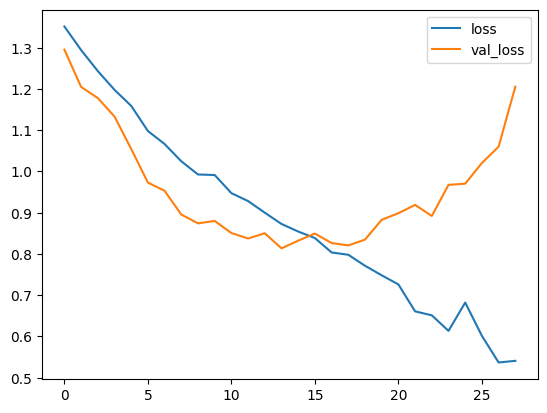

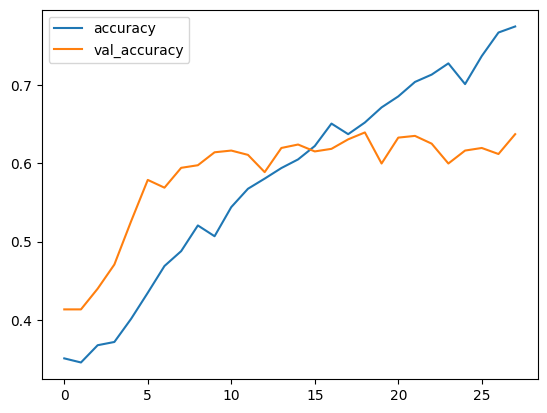

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
print("\n")
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

**Model 1 Evaluation**

In [ ]:
predictions = model1.predict(X_valid)
predicted_labels = np.argmax(predictions, axis=1)

accu = accuracy_score(predicted_labels, y_valid)
pre = precision_score(predicted_labels, y_valid,average = "weighted")
f1 = f1_score(predicted_labels, y_valid,average = "weighted")
print("Accuracy:",accu)
print("\nPrecision:",pre)
print("\nF1-Score:",f1)

29/29 [==============================] - 3s 84ms/step
Accuracy: 0.639470782800441

Precision: 0.6384622646221403

F1-Score: 0.6388308302959559


In [ ]:
# Save the model1
model1.save('model1.h5')

**RoBERTa**

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
train = pd.read_excel("/content/LabeledText.xlsx")

In [ ]:
train_preprocessed = preprocessing(train)

In [ ]:
train = train_preprocessed
train

,File Name,Caption,LABEL
0,1.txt,how i feel today legday jelli ach gym,0
1,10.txt,arrivatw absolut disgrac two carriag from bang...,0
2,100.txt,thi be my valentin s from of my nephew i be el...,2
3,1000.txt,betterfeelingfilm rt via instagram first day o...,1
4,1001.txt,zoe s first love rattl johnnyharp,2
...,...,...,...
4857,989.txt,big thank you to all of the teacher who attend...,2
4858,99.txt,dave look so elat,2
4860,991.txt,complet uniqu petrifi palm ear set in sterl si...,1
4861,992.txt,rt headquart to be fair everyth make i want to...,0


In [ ]:
new_df = train[['Caption', 'LABEL']]
new_df.drop_duplicates(subset=['Caption'], inplace=True)
new_df.head()

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,positive


**Parameters**

In [ ]:
MAX_LEN = 150
TRAIN_BATCH_SIZE = 7
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Caption
        self.targets = self.data.LABEL.map({'positive': 0, 'neutral': 1, 'negative': 2})  # Map labels to integers
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation= True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)  # Using torch.long for integer targets
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=42) #200 was here
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

In [ ]:
print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

FULL Dataset: (4869, 2)
TRAIN Dataset: (3895, 2)
TEST Dataset: (974, 2)


In [ ]:
training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# class RobertaClass(torch.nn.Module):
#     def __init__(self):
#         super(RobertaClass, self).__init__()
#         self.l1 = RobertaModel.from_pretrained("roberta-base")
#         self.pre_classifier = torch.nn.Linear(768, 768)
#         self.dropout = torch.nn.Dropout(0.7)
#         self.classifier = torch.nn.Linear(768, 5)

#     def forward(self, input_ids, attention_mask, token_type_ids):
#         output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.ReLU()(pooler)
#         pooler = self.dropout(pooler)
#         output = self.classifier(pooler)
#         return output

In [ ]:
'''??? from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Vectorize the messages
messages_list = [" ".join(messages)]
tokenized_inputs = tokenizer(messages_list, return_tensors="pt", padding=True, truncation=True)

# Print the tokenized inputs
print(tokenized_inputs)'''

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.classifier = torch.nn.Linear(768, 3)  # Adjusted classifier for direct output

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = torch.nn.ReLU()(pooler)     # Extracting the pooled representation
        pooler = torch.nn.Dropout(0.7)(pooler)  # Apply dropout directly
        output = self.classifier(pooler)  # Directly feed pooled representation to the classifier
        return output

In [ ]:
model2 = RobertaClass()
model2.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model2.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

**RoBERTa Training Function definition**

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model2.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model2(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    # print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

**Model Training**

In [ ]:
EPOCHS = 1
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 1.0809173583984375
Training Accuracy per 5000 steps: 28.571428571428573


557it [1:49:20, 11.78s/it]


The Total Accuracy for Epoch 0: 52.34916559691913
Training Accuracy Epoch: 52.34916559691913


0it [00:00, ?it/s]

Training Loss per 5000 steps: 1.3194464445114136
Training Accuracy per 5000 steps: 42.857142857142854


400it [1:17:18, 11.75s/it]

**RoBERTa - Validation**

In [ ]:
predictions_model2 = []

In [ ]:
def valid(model, testing_loader):
    model2.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model2(ids, mask, token_type_ids).squeeze()
            predictions_model2.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    print(outputs)

    return epoch_accu

**RoBERTa Val Accuracy**

In [ ]:
acc = valid(model2, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

NameError: name 'model2' is not defined

In [ ]:
max_samples = max(len(predictions), len(predictions_model2))
padded_predictions_model1 = np.pad(predictions, (0, max_samples - len(predictions)), mode='constant')

# Combine padded predictions into a feature matrix
combined_predictions = np.column_stack((padded_predictions_model1, predictions_model2))

NameError: name 'predictions' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Adjust target labels to match the size of combined_predictions
y_valid_adjusted = np.pad(y_valid, (0, max_samples - len(y_valid)), mode='constant')

lr = LogisticRegression()
lr.fit(combined_predictions, y_valid_adjusted)
meta_predictions = lr.predict(combined_predictions)

meta_accuracy = accuracy_score(y_valid_adjusted, meta_predictions)
print("Meta-Learner Accuracy:", meta_accuracy)

In [ ]:
predicted_sentiments = le.inverse_transform(meta_predictions)
print("Predicted Sentiment List:", predicted_sentiments)

In [ ]:
from collections import Counter

sentiment_counts = Counter(predicted_sentiments)
final_sentiment = sentiment_counts.most_common(1)[0][0]

print("Sentiment dedected:", final_sentiment)

**Chat History**

In [ ]:
chat = "/content/WhatsApp Chat.txt"

In [ ]:
from collections import defaultdict

In [ ]:
fc = "/content/WhatsApp Chat.txt"

In [ ]:
import re
from collections import defaultdict

def extract_english_words(text):
    english_words = []
    # Regular expression pattern to match English words
    english_pattern = re.compile(r'\b[a-zA-Z]+\b')
    # Find all English words in the text
    english_words = english_pattern.findall(text)
    return english_words

def process_whatsapp_file(file_path):
    user_messages = defaultdict(list)
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the lines of the WhatsApp chat history file
        lines = file.readlines()

    current_user = None
    for line in lines:
        # Split each line by the timestamp and sender's name
        parts = line.split(' - ')
        if len(parts) > 1:
            user_message = parts[1].strip()  # Extract the user name and message content
            user_parts = user_message.split(': ')
            if len(user_parts) > 1:
                user = user_parts[0].strip()  # Extract the user name
                message = ': '.join(user_parts[1:]).strip()  # Reconstruct the message part

                # Check if the user has changed
                if user != current_user:
                    # If the user has changed, reset the current_user variable
                    current_user = user
                    # Initialize an empty list for the user if it's the first message from that user
                    if not user_messages[current_user]:
                        user_messages[current_user] = []

                # Extract English words from the message and add them to the corresponding user's list
                english_words = extract_english_words(message)
                user_messages[current_user].extend(english_words)

    return user_messages

# Path to your WhatsApp chat history file
whatsapp_file_path = fc

# Process the WhatsApp chat history file
user_messages = process_whatsapp_file(whatsapp_file_path)

# Print the dictionaries along with the corresponding user names
for user, messages in user_messages.items():
    print(f"User: {user}")
    print(f"messages: {messages}\n")

In [ ]:
messages1 = user_messages["Karthi"]
messages2 = user_messages["Haleem Cres"]

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_words,
    output_mode='int',
    output_sequence_length=maxlen
)

# Adapt the layer to the new messages
vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices([" ".join(messages1)]).batch(1))

# Convert the messages into numerical vectors
message_vectors = vectorize_layer([" ".join(messages)])

# Add a batch dimension to the message vectors
message_vectors = tf.expand_dims(message_vectors, axis=0)
message_vectors = tf.reshape(message_vectors, (1, 200))

In [ ]:
message_vectors

In [ ]:
try:
    # Use the model to predict the sentiment of the messages
    predictions = model1.predict(message_vectors)

    # Get the predicted sentiment labels
    predicted_labels = np.argmax(predictions, axis=1)

    print(f"Predicted sentiment label: {predicted_labels[0]}")
except Exception:
  predictions = 0
  predicted_labels = np.argmax(predictions)
  print(f"Predicted sentiment label: {predicted_labels}")

In [ ]:
0